# Подготовка

In [507]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from statsmodels.tsa.seasonal import seasonal_decompose

import os

In [508]:
BASE_DIR = os.getcwd()

In [509]:
df = pd.read_csv(f'{BASE_DIR}/datasets/BTC-USD(4).csv')
supply = pd.read_csv(f'{BASE_DIR}/datasets/GLASSNODE_BTC_BLOCKS, 1D.csv')

In [510]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    4846 non-null   object 
 1   open    4846 non-null   float64
 2   high    4846 non-null   float64
 3   low     4846 non-null   float64
 4   close   4846 non-null   float64
dtypes: float64(4), object(1)
memory usage: 189.4+ KB


In [511]:
df['time'] = pd.to_datetime(df['time'])

In [512]:
df = df.set_index(df['time']).drop('time', axis=1)
df = df.drop(['open','high','low'], axis=1)
df = df.astype('float')

In [513]:
df_d = df[['close']]

<AxesSubplot:xlabel='time'>

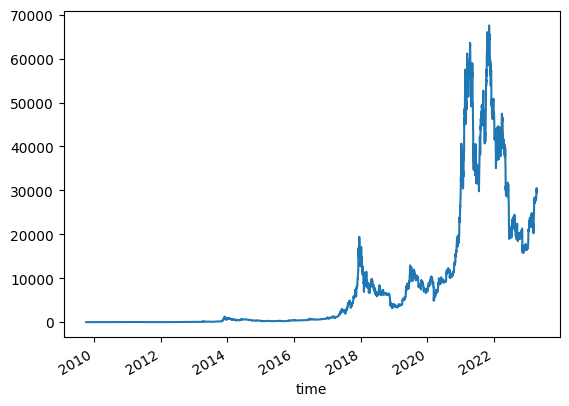

In [514]:
df_d['close'].plot(kind='line')

Сводный график BTC к эмиссии

In [515]:
supply.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5212 entries, 0 to 5211
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   time    5212 non-null   object
 1   open    5212 non-null   int64 
 2   high    5212 non-null   int64 
 3   low     5212 non-null   int64 
 4   close   5212 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 203.7+ KB


In [516]:
supply['time'] = pd.to_datetime(supply['time'])
supply = supply.set_index(supply['time']).drop('time', axis=1)
supply = supply.drop(['open','high','low'], axis=1)
supply = supply.astype('float')

<AxesSubplot:xlabel='time'>

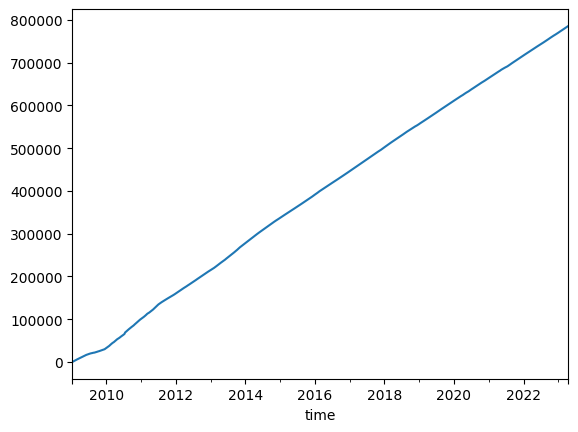

In [517]:
supply['close'].plot(kind='line')

<AxesSubplot:xlabel='time'>

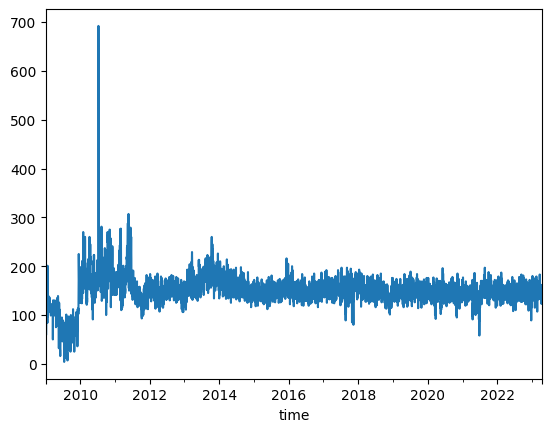

In [518]:
(supply['close'] - supply['close'].shift(1)).plot(kind='line')

In [519]:
supply['close2'] = supply['close']
supply = supply.drop(['close'], axis=1)

In [520]:
df_new =df.join(supply, how='inner')

In [521]:
df_new

,close,close2
time,,
2009-10-05 00:00:00+00:00,0.000764,24418.0
2009-10-06 00:00:00+00:00,0.000885,24461.0
2009-10-07 00:00:00+00:00,0.001050,24521.0
2009-10-08 00:00:00+00:00,0.001084,24591.0
2009-10-09 00:00:00+00:00,0.001200,24671.0
...,...,...
2023-04-13 00:00:00+00:00,30407.470000,785290.0
2023-04-14 00:00:00+00:00,30495.030000,785430.0
2023-04-15 00:00:00+00:00,30324.640000,785588.0


In [522]:
df_new.rename(columns={'close2': 'time'}, inplace=True)


<AxesSubplot:xlabel='time'>

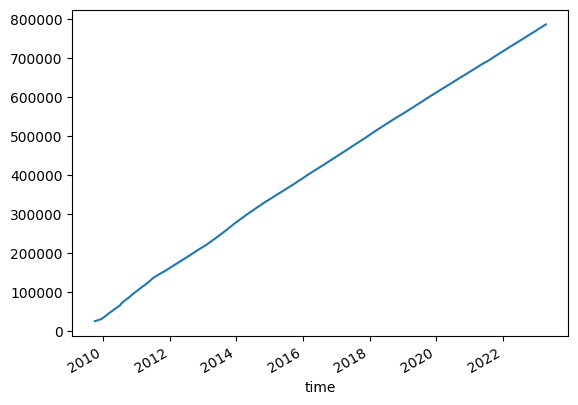

In [523]:
df_new['time'].plot(kind='line')

In [524]:

df_new.set_index('time', inplace=True)

<AxesSubplot:xlabel='time'>

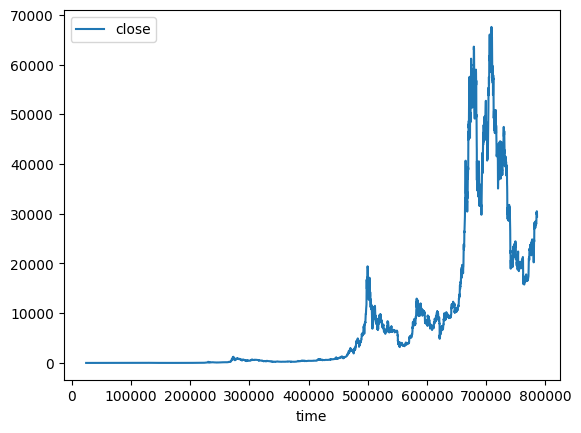

In [525]:
df_new.plot(kind='line')

In [526]:
df_w = df_new

In [527]:
# df_w = df.resample('1M').mean()

In [528]:
df_w.head()

,close
time,
24418.0,0.000764
24461.0,0.000885
24521.0,0.001050
24591.0,0.001084
24671.0,0.001200


<AxesSubplot:xlabel='time'>

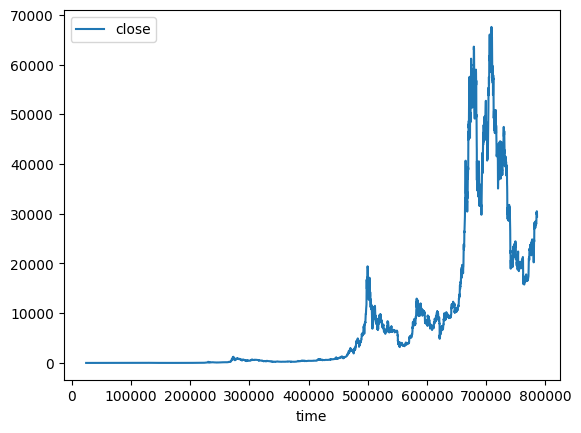

In [529]:
df_w.plot(kind='line')

## Метод Бокса-Кокса

In [530]:
from scipy import stats

In [531]:
df_wbox = df_w.copy()
df_wbox['close'], lambd = stats.boxcox(df_w['close'])

In [532]:
lambd

0.13134561458013058

In [533]:
df_wbox.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4845 entries, 24418.0 to 785867.0
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   4845 non-null   float64
dtypes: float64(1)
memory usage: 75.7 KB


<AxesSubplot:xlabel='time'>

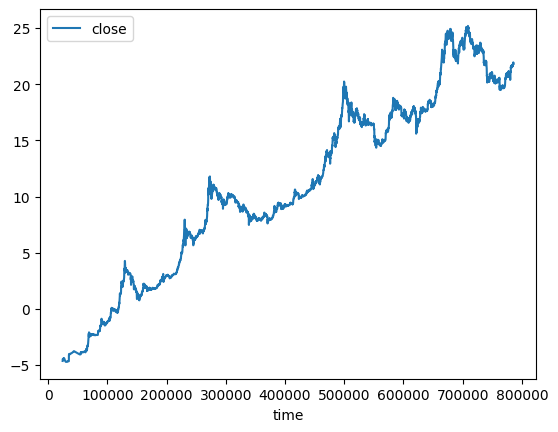

In [534]:
# df_wbox['close'] = df_wbox['close'].resample('1M').mean()
df_wbox.plot(kind='line')

## LOWESS (Locally Weighted Scatterplot Smoothing)

Отдельно ищем тренд

In [535]:
from statsmodels.nonparametric.smoothers_lowess import lowess

Подбираем frac чтобы в остатке был минимальные p-value в тесте Дики-Фуллера

In [536]:
from statsmodels.tsa.stattools import adfuller
pval = {}
"""
for i in range(60,101):
    trend = pd.DataFrame(lowess(df_wbox['close'], df_wbox.index, frac=i/100, it=3, return_sorted=False))
    # trend.plot(kind='line')
    trend.set_index(df_wbox.index, inplace=True)
    df_wbox_t = df_wbox.copy()
    df_wbox_t['close'] = (df_wbox['close'] - trend[0])
    # df_wbox_t.plot(kind='line')


    result = adfuller(df_wbox_t)
    # print('ADF Statistic:', result[0])
    # print('p-value:', result[1])
    # print('Critical Values:', result[4])
    print (i, result[1])
    if not result[1] is None:
        pval[i] = result[1]
        """


"\nfor i in range(60,101):\n    trend = pd.DataFrame(lowess(df_wbox['close'], df_wbox.index, frac=i/100, it=3, return_sorted=False))\n    # trend.plot(kind='line')\n    trend.set_index(df_wbox.index, inplace=True)\n    df_wbox_t = df_wbox.copy()\n    df_wbox_t['close'] = (df_wbox['close'] - trend[0])\n    # df_wbox_t.plot(kind='line')\n\n\n    result = adfuller(df_wbox_t)\n    # print('ADF Statistic:', result[0])\n    # print('p-value:', result[1])\n    # print('Critical Values:', result[4])\n    print (i, result[1])\n    if not result[1] is None:\n        pval[i] = result[1]\n        "

In [537]:
# min_val = min(pval.values())
# min_key = list(pval.keys())[list(pval.values()).index(min_val)]
# print(min_key)

ADF Statistic: -2.5737520790715718
p-value: 0.09854442742110675
Critical Values: {'1%': -3.4317096824174698, '5%': -2.862140827434085, '10%': -2.5670898220592187}


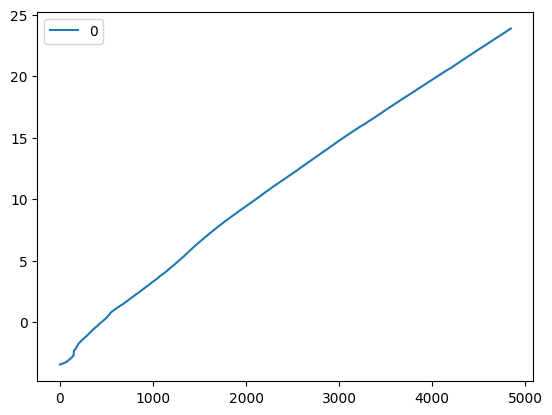

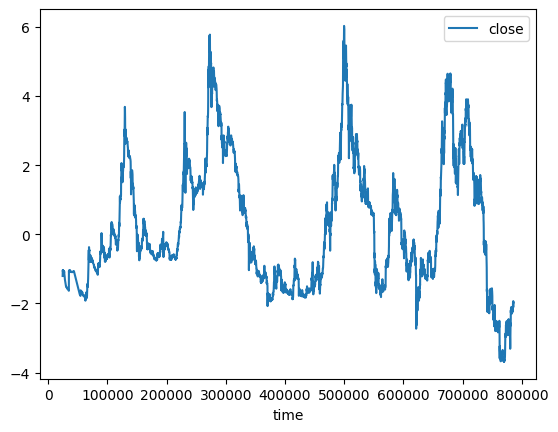

In [544]:
trend = pd.DataFrame(lowess(df_wbox['close'], df_wbox.index, frac=90/100, it=3, return_sorted=False))
trend.plot(kind='line')
trend.set_index(df_wbox.index, inplace=True)
df_wbox_t = df_wbox.copy()
df_wbox_t['close'] = (df_wbox['close'] - trend[0])
df_wbox_t.plot(kind='line')


result = adfuller(df_wbox_t)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

<AxesSubplot:xlabel='time'>

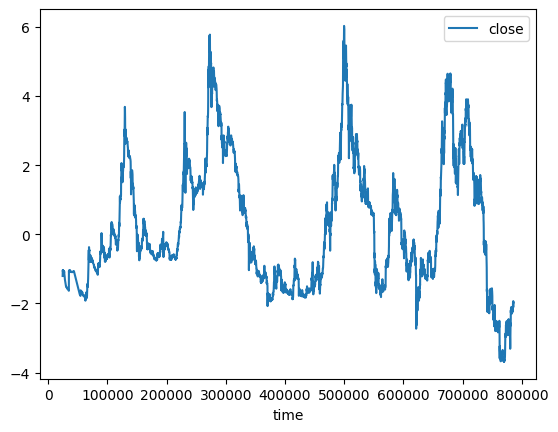

In [548]:
df_wbox_t.plot(kind='line')

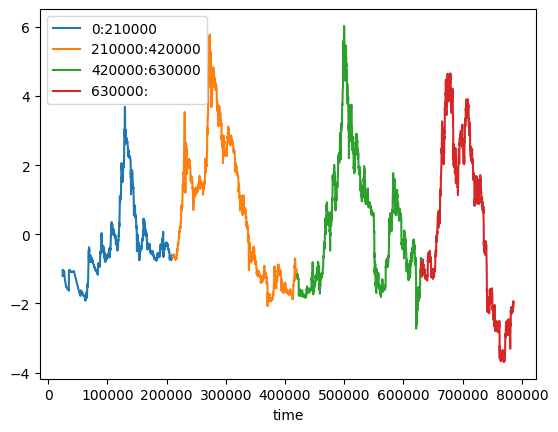

In [740]:
import matplotlib.pyplot as plt

# создать объект Axes
fig, ax = plt.subplots()

# наложить графики на один график
df_wbox_t[0:210000].plot(kind='line', ax=ax)
df_wbox_t[210000:420000].plot(kind='line', ax=ax)
df_wbox_t[420000:630000].plot(kind='line', ax=ax)
df_wbox_t[630000:].plot(kind='line', ax=ax)

# добавить легенду
ax.legend(['0:210000', '210000:420000', '420000:630000', '630000:'])

# показать график
plt.show()


In [756]:
import pandas as pd
import matplotlib.pyplot as plt

# находим начальные дату и время для каждого графика
start_time_1 = df_wbox_t[0:210000].index.min()
start_time_2 = df_wbox_t[210000:420000].index.min()
start_time_3 = df_wbox_t[420000:630000].index.min()
start_time_4 = df_wbox_t[630000:].index.min()

In [763]:
# вычитаем начальную дату и время из индекса каждого графика
df_wbox_t1 = df_wbox_t[0:210000]
df_wbox_t1.index = df_wbox_t1.index - start_time_1
df_wbox_t2 = df_wbox_t[210000:420000]
df_wbox_t2.index = df_wbox_t2.index - start_time_2
df_wbox_t3 = df_wbox_t[420000:630000]
df_wbox_t3.index = df_wbox_t3.index - start_time_3
df_wbox_t4 = df_wbox_t[630000:]
df_wbox_t4.index = df_wbox_t4.index - start_time_4

In [780]:
import pandas as pd

# объединяем временные ряды в один DataFrame
df = df_wbox_t1.copy()

((df_wbox_t1['close'].reset_index(drop=True) + df_wbox_t2['close'].reset_index(drop=True))/2)


0      -0.927436
1      -0.896822
2      -0.859418
3      -0.857626
4      -0.844417
          ...   
1307         NaN
1308         NaN
1309         NaN
1310         NaN
1311         NaN
Name: close, Length: 1312, dtype: float64

In [ ]:

# заполняем значения NaN в последнем столбце
df.iloc[:, -1] = df.iloc[:, -1].fillna(value=pd.NaT)

# вычисляем среднее значение
mean_series = df.mean(axis=1)


In [771]:
df_wbox_t4

,close
time,
0.0,-1.215368
146.0,-1.125059
265.0,-0.949114
379.0,-0.787633
504.0,-0.959051
...,...
155267.0,-1.941146
155407.0,-1.934694
155565.0,-1.961745


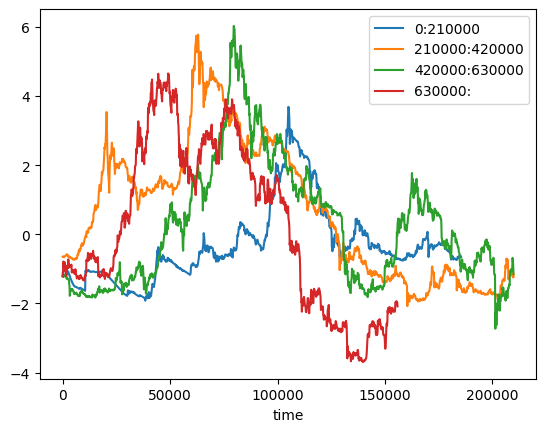

In [764]:

# создаем объект Axes
fig, ax = plt.subplots()

# наложение графиков на один график
df_wbox_t1.plot(kind='line', ax=ax)
df_wbox_t2.plot(kind='line', ax=ax)
df_wbox_t3.plot(kind='line', ax=ax)
df_wbox_t4.plot(kind='line', ax=ax)


# добавление легенды
ax.legend(['0:210000', '210000:420000', '420000:630000', '630000:'])

# показать график
plt.show()


<AxesSubplot:>

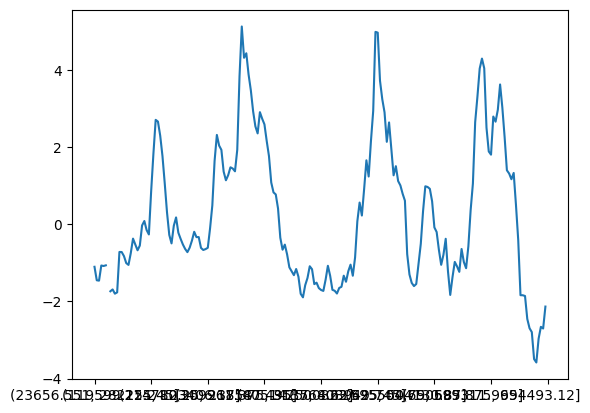

In [645]:
import pandas as pd

batch_size = 10

# Разбиваем индекс на батчи
batches = pd.cut(df_wbox_t.index, bins=200)

# Группируем значения по батчам и применяем агрегирующую функцию mean
grouped = df_wbox_t.groupby(batches)['close'].mean()

grouped.plot(kind='line')

In [588]:
grouped.index.is_monotonic

C:\Users\danii\AppData\Local\Temp\ipykernel_18376\3545474197.py:1: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  grouped.index.is_monotonic


True

In [631]:
grouped_rescale = pd.DataFrame(grouped).reset_index(drop=True).fillna(method='ffill')

<AxesSubplot:>

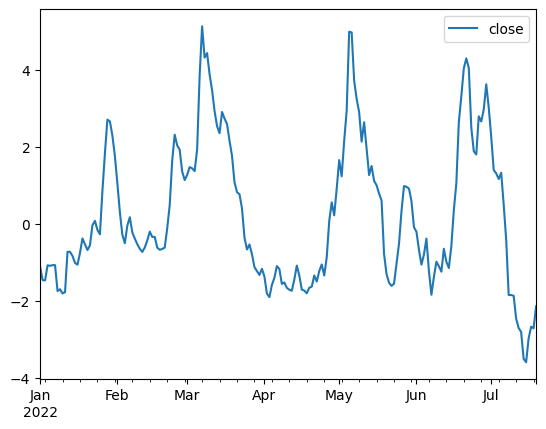

In [646]:
grouped_rescale.plot(kind='line')

## Автокорреляция

<AxesSubplot:xlabel='time'>

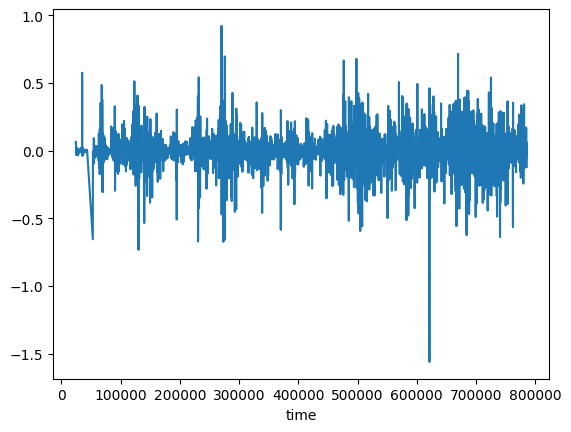

In [539]:
(df_wbox_t['close'] - df_wbox_t['close'].shift(1)).plot(kind='line')

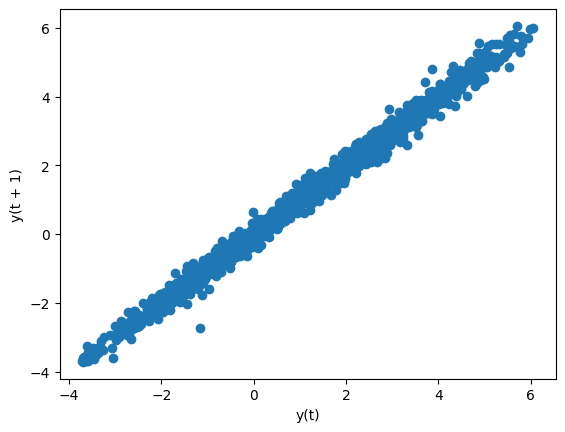

In [540]:
from pandas import read_csv
from matplotlib import pyplot
from pandas.plotting import lag_plot
lag_plot(df_wbox_t['close'],1)
pyplot.show()

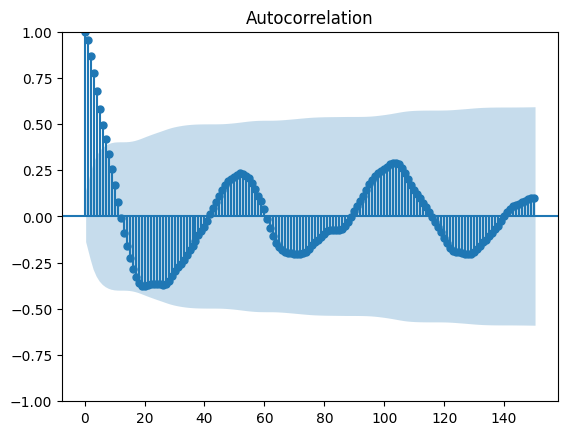

In [648]:
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(grouped_rescale['close'], lags=150)
pyplot.show()

## Вычленение сезонности с плавающим периодом

Для определения пиков можно использовать пересечение 111MA и 350MA

In [542]:
# df_d['close'].rolling(111).mean().plot(kind='line')
# (df_d['close'].rolling(350).mean()*2).plot(kind='line')

In [636]:
start_date = '2022-01-01'
freq = 'D'
grouped_rescale.index = pd.date_range(start_date, periods=len(grouped_rescale), freq=freq)
print(grouped_rescale)


               close
2022-01-01 -1.103424
2022-01-02 -1.452821
2022-01-03 -1.462419
2022-01-04 -1.070121
2022-01-05 -1.082994
...              ...
2022-07-15 -3.582067
2022-07-16 -2.965148
2022-07-17 -2.659315
2022-07-18 -2.702085
2022-07-19 -2.133864

[200 rows x 1 columns]


In [642]:
decomposed = seasonal_decompose(grouped_rescale['close'])
decomposed.trend.plot()

AttributeError: 'DataFrame' object has no attribute 'startswith'

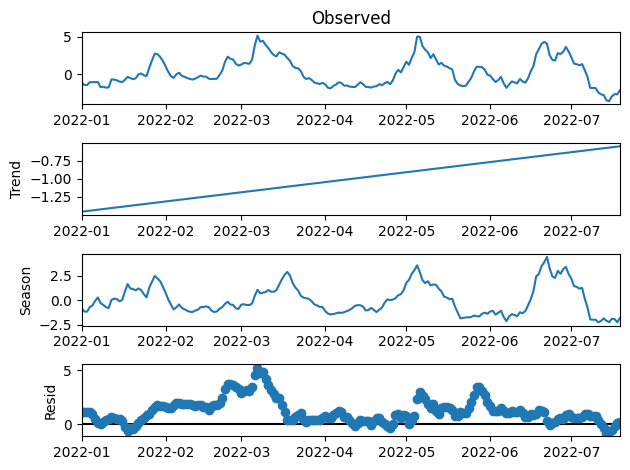

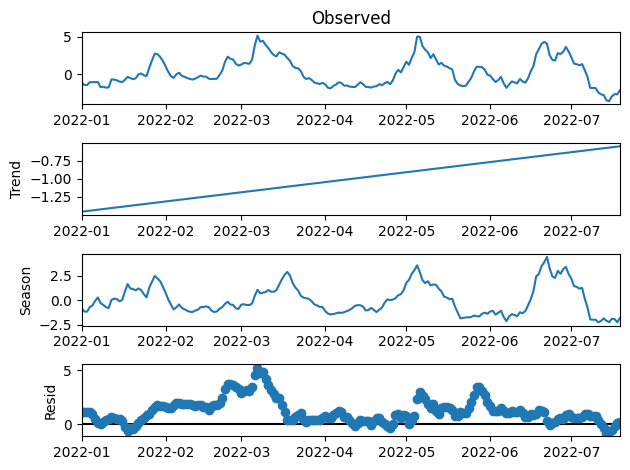

In [736]:
from statsmodels.tsa.seasonal import STL
stl_kwargs = {"seasonal_deg": 0} 
model = STL(grouped_rescale, trend_jump=1000, period=48)
res = model.fit()
res.plot()

<AxesSubplot:>

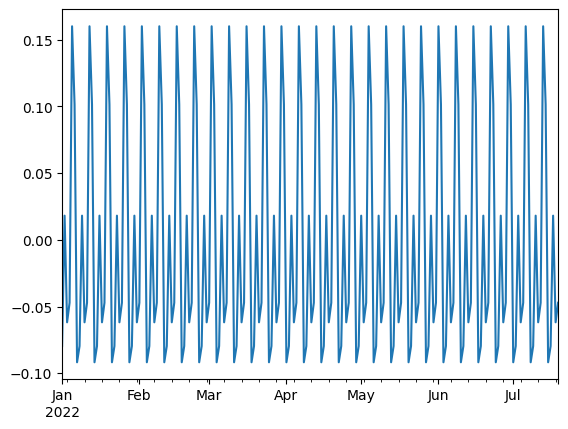

In [638]:
decomposed.seasonal.plot()

<AxesSubplot:>

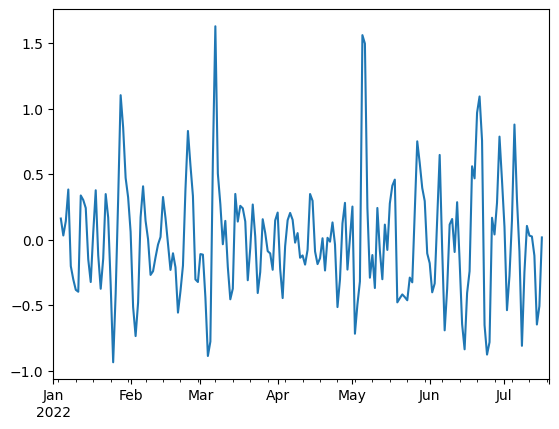

In [639]:
decomposed.resid.plot()

## Получение стационарного остатка + ARIMA

Кореллограмма
Найти циклы (переменная сезонность)
Выровнить график, логарифмическая шкала + логарифмическая кривая, мб квадратичная функция
Логарифмирование-частный случай бокс-кокса стабилизация дисперсии 
Дифференцирование yt - y(t-1)

In [ ]:
# decomposed = seasonal_decompose(df_d['2018-04-01':'2018-10-1'])
# decomposed.trend.plot()
# decomposed.seasonal.plot()
# decomposed.resid.plot()

In [ ]:
df_wn = (df_w - df_w.shift())

<AxesSubplot:xlabel='time'>

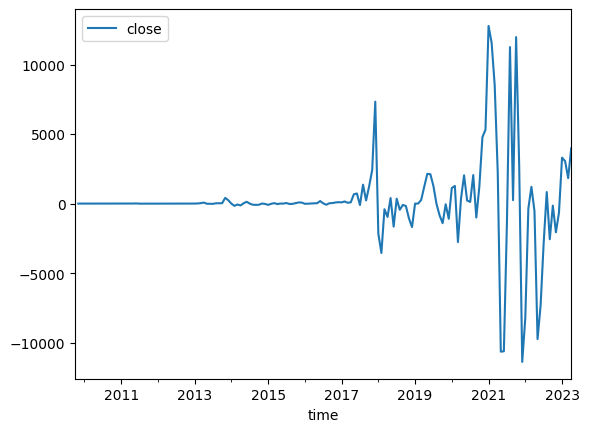

In [ ]:
df_wn.plot(kind='line')